In [2]:
# Step 1: Import & Load Data
!pip install pulp
import pandas as pd
import numpy as np
import pulp as pl
import matplotlib.pyplot as plt

# Load diary data
file_path = "data/my_diary_30days.csv"
diary = pd.read_csv(file_path, parse_dates=["date"])
print(diary.head())  # Quick check


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 88.9 MB/s eta 0:00:00


FileNotFoundError: [Errno 2] No such file or directory: 'data/my_diary_30days.csv'

In [ ]:
activities = pd.DataFrame({
    "activity": [ "Classes","Study_1","Study_2","Study_3","Sleep",
        "Exercise","Research_Project","Social"],
    "min_hours":[15, 0, 0, 0, 49, 0, 0, 0],
    "max_hours":[15,15,15,15, 56, 7, 15, 14],
    "utility_per_hour":[2.0,1.6,1.3,0.9, 1.8,1.1,1.3,0.7]
})
activities


,activity,min_hours,max_hours,utility_per_hour
0,Classes,15,15,2.0
1,Study_1,0,15,1.6
2,Study_2,0,15,1.3
3,Study_3,0,15,0.9
4,Sleep,49,56,1.8
5,Exercise,0,7,1.1
6,Research_Project,0,15,1.3
7,Social,0,14,0.7


In [ ]:
file_path = "/content/my_diary_30days.csv"
diary = pd.read_csv(file_path, parse_dates=["date"])

print(diary.head())

X = diary[["Study","Sleep","Exercise","Research","Social"]].values
y = diary["Efficiency"].values

X_design = np.column_stack([np.ones(len(X)), X])
coef, *_ = np.linalg.lstsq(X_design, y, rcond=None)
bias, b_study, b_sleep, b_ex, b_res, b_soc = coef

print("Regression coefficients:")
print(f"Study={b_study:.3f}, Sleep={b_sleep:.3f}, Exercise={b_ex:.3f}, Research={b_res:.3f}, Social={b_soc:.3f}")


raw = np.array([max(0, b_study), max(0, b_sleep), max(0, b_ex), max(0, b_res), max(0, b_soc)])
if raw.sum() == 0:
    weights = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
else:
    weights = raw / raw.mean()

print("Normalized weights (larger means more important):", weights.round(2))

study_w, sleep_w, ex_w, res_w, soc_w = weights
study_base = 1.3
activities.loc[activities.activity=="Study_1","utility_per_hour"] = study_base*1.0*study_w
activities.loc[activities.activity=="Study_2","utility_per_hour"] = study_base*0.8*study_w
activities.loc[activities.activity=="Study_3","utility_per_hour"] = study_base*0.6*study_w
activities.loc[activities.activity=="Sleep",  "utility_per_hour"] = 1.2*sleep_w
activities.loc[activities.activity=="Exercise","utility_per_hour"] = 1.0*ex_w
activities.loc[activities.activity=="Research_Project","utility_per_hour"] = 1.1*res_w
activities.loc[activities.activity=="Social","utility_per_hour"] = 0.7*soc_w

activities

        date  Study  Sleep  Exercise  Research  Social  Efficiency
0 2025-08-01      5    8.4       0.0         0       0           2
1 2025-08-02      4    7.4       1.5         1       0           4
2 2025-08-03      3    7.9       0.0         1       0           3
3 2025-08-04      6    7.4       1.5         2       1           5
4 2025-08-05      5    8.4       1.0         2       1           5
Regression coefficients:
Study=0.457, Sleep=-0.155, Exercise=0.322, Research=0.622, Social=0.470
Normalized weights (larger means more important): [1.22 0.   0.86 1.66 1.26]


,activity,min_hours,max_hours,utility_per_hour
0,Classes,15,15,2.000000
1,Study_1,0,15,1.586364
2,Study_2,0,15,1.269091
3,Study_3,0,15,0.951818
4,Sleep,49,56,0.000000
5,Exercise,0,7,0.861483
6,Research_Project,0,15,1.828146
7,Social,0,14,0.879400


In [ ]:
activities = pd.DataFrame({
        "activity": ["Classes","Study_1","Study_2","Study_3",
            "Sleep","Exercise","Research_Project","Social"],
        "min_hours":[15, 0, 0, 0, 49, 0, 0, 0],
        "max_hours":[15,20,15,15, 56, 12,15,20],
        "utility_per_hour":[2.0,1.6,1.3,0.9, 1.8,1.1,1.3,0.7]
    })

model = pl.LpProblem("Time_Allocation", pl.LpMaximize)

h = {}
for _, row in activities.iterrows():
    name = row["activity"]
    h[name] = pl.LpVariable(
        f"h_{name}",
        lowBound=float(row["min_hours"]),
        upBound=float(row["max_hours"]),
        cat="Continuous"
    )

objective_terms = []
for _, row in activities.iterrows():
    utility = float(row["utility_per_hour"])
    var     = h[row["activity"]]
    objective_terms.append(utility * var)
model += pl.lpSum(objective_terms)

model += pl.lpSum(h.values()) == 168

status = model.solve(pl.PULP_CBC_CMD(msg=False))

print("Solver status:", pl.LpStatus[status])

opt_hours = {name: pl.value(var) for name, var in h.items()}
opt = pd.Series(opt_hours, name="opt_hours").sort_index()
print(opt)
print("Total hours =", opt.sum())

Solver status: Optimal
Classes             15.0
Exercise            12.0
Research_Project    15.0
Sleep               56.0
Social              20.0
Study_1             20.0
Study_2             15.0
Study_3             15.0
Name: opt_hours, dtype: float64
Total hours = 168.0


Real Baseline（average hours per week）:
Classes             15.000000
Exercise             3.966667
Research_Project     7.233333
Sleep               51.846667
Social               6.066667
Study_1             14.700000
Study_2              8.820000
Study_3              5.880000
Name: baseline, dtype: float64

 TotalHours = 113.51333333333335
Mask (True = keep, False = drop):
[ True  True  True  True  True  True  True  True]

Baseline after filtering:
Classes             15.000000
Exercise             3.966667
Research_Project     7.233333
Sleep               51.846667
Social               6.066667
Study_1             14.700000
Study_2              8.820000
Study_3              5.880000
Name: baseline, dtype: float64

Baseline after sorting:
Classes             15.000000
Exercise             3.966667
Research_Project     7.233333
Sleep               51.846667
Social               6.066667
Study_1             14.700000
Study_2              8.820000
Study_3              5.880000
Name: bas

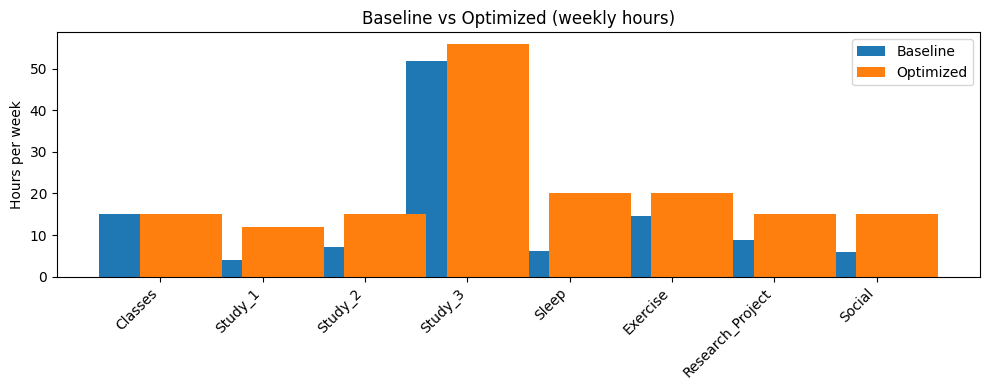

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1000x400 with 0 Axes>

In [ ]:
file_path = "my_diary_30days.csv"
diary_30 = pd.read_csv(file_path, parse_dates=["date"])

daily_avg = diary_30[["Study","Sleep","Exercise","Research","Social"]].mean()

weekly_avg = daily_avg * 7

baseline_dict = {
    "Classes": 15,
    "Study_1": weekly_avg["Study"] * 0.5,
    "Study_2": weekly_avg["Study"] * 0.3,
    "Study_3": weekly_avg["Study"] * 0.2,
    "Sleep": weekly_avg["Sleep"],
    "Exercise": weekly_avg["Exercise"],
    "Research_Project": weekly_avg["Research"],
    "Social": weekly_avg["Social"]
}

baseline = pd.Series(baseline_dict, name="baseline").sort_index()

print("Real Baseline（average hours per week）:")
print(baseline)
print("\n TotalHours =", baseline.sum())

mask = baseline.index.isin(activities["activity"])
print("Mask (True = keep, False = drop):")
print(mask)

baseline_cleaned = baseline[mask]
print("\nBaseline after filtering:")
print(baseline_cleaned)

baseline_sorted = baseline_cleaned.sort_index()
print("\nBaseline after sorting:")
print(baseline_sorted)

baseline = baseline_sorted

opt_aligned = opt.sort_index()

b = baseline.sort_index()
o = opt_aligned.sort_index()

print("Baseline total hours:", b.sum())
print("Optimized total hours:", o.sum())

diff = (o - b).sort_values(ascending=False)
print("\nTop increases (opt - base):")
print(diff.head(3))
print("\nTop decreases (opt - base):")
print(diff.tail(3))

import matplotlib.pyplot as plt

labels = ["Classes","Study_1","Study_2","Study_3",
          "Sleep","Exercise","Research_Project","Social"]
x = range(len(labels))
plt.figure(figsize=(10, 4))

plt.bar(x, b.values, label="Baseline")
plt.bar([i+0.4 for i in x],
        o.values, label="Optimized")

plt.xticks([i+0.2 for i in x],
           labels, rotation=45, ha="right")
plt.ylabel("Hours per week")
plt.title("Baseline vs Optimized (weekly hours)")
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig("baseline_vs_optimized.png", dpi=200)
from google.colab import files
files.download("baseline_vs_optimized.png")





In [ ]:

from datetime import datetime, timedelta
from ics import Calendar, Event

def export_opt_to_ics(opt: pd.Series,
                      filename="optimal_schedule.ics",
                      week_start=None,
                      day_start_hour=8):

    if week_start is None:
        today = datetime.utcnow().date()
        week_start = today + timedelta(days=(7 - today.weekday()) % 7)

    per_day = (opt / 7).to_dict()

    order = [a for a in ["Classes","Study_1","Study_2","Research_Project",
                         "Exercise","Study_3","Social","Sleep"]
             if a in per_day and per_day[a] > 1e-6]

    cal = Calendar()

    for d in range(7):
        day0 = datetime.combine(week_start + timedelta(days=d), datetime.min.time())

        cursor = day0 + timedelta(hours=day_start_hour)

        sleep_hours = 0.0

        for act in order:
            hours = float(per_day[act])
            if hours <= 0:
                continue
            if act == "Sleep":
                sleep_hours = hours
                continue

            e = Event(name=act)
            e.begin = cursor
            e.end = cursor + timedelta(hours=hours)
            cal.events.add(e)
            cursor = e.end

        if sleep_hours > 0:

            sleep_start = day0 + timedelta(hours=23 - max(0, sleep_hours - 1))
            e = Event(name="Sleep")
            e.begin = sleep_start
            e.end = sleep_start + timedelta(hours=sleep_hours)
            cal.events.add(e)


    with open(filename, "w") as f:
        f.writelines(cal.serialize_iter())
    print(f"ICS saved to: {filename}")
    return filename

ics_path = export_opt_to_ics(opt, filename="optimal_schedule.ics")

try:
    from google.colab import files
    files.download(ics_path)
except Exception as e:
    print("If you are not in a Colab environment, please manually download the file from the current working directory.", e)

ICS saved to: optimal_schedule.ics


/tmp/ipython-input-2307446846.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = datetime.utcnow().date()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>